# Dark Vessel Detection

## Imports

In [18]:
# Import libraries
import os
import glob
import pandas as pd
import numpy as np
import random

import cv2
import rasterio
from rasterio.windows import Window

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from google.colab import drive
import gcsfs

In [19]:
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

### Setting up the cloud environment

In [2]:
# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# Setting the project directories
BASE_DIR = '/content/drive/MyDrive/Data_Science/Dark-Vessel-Detection/DarkVessel_Dataset'
DIRS = {
    'train_img': os.path.join(BASE_DIR, 'images/train'),
    'val_img': os.path.join(BASE_DIR, 'images/val'),
    'train_lbl': os.path.join(BASE_DIR, 'labels/train'),
    'val_lbl': os.path.join(BASE_DIR, 'labels/val')
}


In [21]:
# Creating the directories
for path in DIRS.values():
    os.makedirs(path, exist_ok=True)
print(f"Directories created at: {BASE_DIR}")

Directories created at: /content/drive/MyDrive/Data_Science/Dark-Vessel-Detection/DarkVessel_Dataset


## Exploratory Data Analysis

In [22]:
# Show a sample ship
def process_sar_core(row, chip_size = 640):
    """ Shows 1 ship and plots the transformations"""

    prod_id = str(row['GRD_product_identifier'])

    # Connect to the sentinel 1 public dataset on AWS
    try:
        start_time = prod_id.split('_')[4]
        year = start_time[0:4]
        month = str(int(start_time[4:6]))
        day = str(int(start_time[6:8]))

        swath = prod_id.split('_')[1]         # IW
        pol_mode = prod_id.split('_')[3][2:4] # 1SDV becomes DV

        # The exact, free AWS S3 database route
        base_uri = f"s3://sentinel-s1-l1c/GRD/{year}/{month}/{day}/{swath}/{pol_mode}/{prod_id}/measurement"
        vv_uri = f"{base_uri}/iw-vv.tiff"
        vh_uri = f"{base_uri}/iw-vh.tiff"

    except Exception as e:
        print(f"Error parsing AWS URI for {prod_id}: {e}")
        return None

    # Bounding Boxes
    g_xmin, g_ymin = int(row['left']), int(row['top'])
    g_xmax, g_ymax = int(row['right']), int(row['bottom'])

    center_x, center_y = (g_xmin + g_xmax) // 2, (g_ymin + g_ymax) // 2
    chip_x, chip_y = max(0, center_x - (chip_size // 2)), max(0, center_y - (chip_size // 2))

    # Data from AWS
    try:
        with rasterio.Env(AWS_NO_SIGN_REQUEST='YES'):
            with rasterio.open(vv_uri) as src_vv, rasterio.open(vh_uri) as src_vh:
                window = Window(chip_x, chip_y, chip_size, chip_size)
                vv_raw = src_vv.read(1, window=window).astype(np.float32)
                vh_raw = src_vh.read(1, window=window).astype(np.float32)

                # Decibel Conversion
                vv_db = 10 * np.log10(vv_raw + 1e-7)
                vh_db = 10 * np.log10(vh_raw + 1e-7)

                # Normalization
                vv_norm = np.clip((vv_db + 30) / 30 * 255, 0, 255).astype(np.uint8)
                vh_norm = np.clip((vh_db + 30) / 30 * 255, 0, 255).astype(np.uint8)
                ratio_norm = np.clip((vv_db - vh_db + 15) / 30 * 255, 0, 255).astype(np.uint8)

                rgb_chip = np.dstack((vv_norm, vh_norm, ratio_norm))

                # YOLO format
                l_xmin, l_ymin = max(0, g_xmin - chip_x), max(0, g_ymin - chip_y)
                l_xmax, l_ymax = min(chip_size, g_xmax - chip_x), min(chip_size, g_ymax - chip_y)

                x_center, y_center = ((l_xmin + l_xmax) / 2.0) / chip_size, ((l_ymin + l_ymax) / 2.0) / chip_size
                width, height = (l_xmax - l_xmin) / chip_size, (l_ymax - l_ymin) / chip_size

                return {
                    'chip_name': f"{prod_id}_{chip_x}_{chip_y}",
                    'rgb_chip': rgb_chip,
                    'yolo_label': f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n",
                    'vv_raw': vv_raw, 'vv_db': vv_db,
                    'vv_norm': vv_norm, 'vh_norm': vh_norm
                }
    except Exception as e:
        print(f"Error {prod_id}: {e}")
        return None

### Extraction

In [23]:
# Visualization
def visualize_sar (row):
    """ Get data and plot"""
    data = process_sar_core(row)

    if not data:
       print("Failed data")
       return

    plt.style.use('dark_background')
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    axes[0,0].imshow(data['vv_raw'], cmap='gray', vmin=0, vmax=np.max(data['vv_raw'])*0.1)
    axes[0,0].set_title("1. Raw Linear VV")
    axes[0,0].axis('off')

    axes[0,1].imshow(data['vv_db'], cmap='gray')
    axes[0,1].set_title("2. Decibel Converted VV")
    axes[0,1].axis('off')

    sns.histplot(data['vv_db'].flatten(), bins=100, ax=axes[0,2], color='cyan', kde=False)
    axes[0,2].axvline(x=0, color='yellow', linestyle='--', label='0dB Threshold')
    axes[0,2].set_title("3. dB Histogram")
    axes[0,2].set_yscale('log')

    axes[1,0].imshow(data['vv_norm'], cmap='gray')
    axes[1,0].set_title("4. Normalized VV (8-bit)")
    axes[1,0].axis('off')

    axes[1,1].imshow(data['vh_norm'], cmap='gray')
    axes[1,1].set_title("5. Normalized VH (8-bit)")
    axes[1,1].axis('off')

    axes[1,2].imshow(data['rgb_chip'])
    axes[1,2].set_title("6. Final Pseudo-RGB Chip for YOLO")
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()



In [24]:
# Save the chips
def save_chip(row, split_type):
    """Saves data to drive"""
    data = process_sar_core(row)

    if not data:
        return false

    # Directories to save the chipped images to
    img_dir = DIRS['train_img'] if split_type == 'train' else DIRS['val_img']
    lbl_dir = DIRS['train_lbl'] if split_type == 'train' else DIRS['val_lbl']

    # Save img
    cv2.imwrite(os.path.join(img_dir, f"{data['chip_name']}.png"), data['rgb_chip'])

    # Save txt file
    with open(os.path.join(lbl_dir, f"{data['chip_name']}.txt"), 'w') as f:
        f.write(data['yolo_label'])

    return True

## Extraction

In [25]:
# Load data
df = pd.read_csv(os.path.join(BASE_DIR, 'labels.csv'))

# Filter off false alarms
df = df[df['is_vessel'] == True]

# Drop columns that are unnecessary
df = df.dropna(subset=['left', 'top', 'right', 'bottom', 'GRD_product_identifier'])

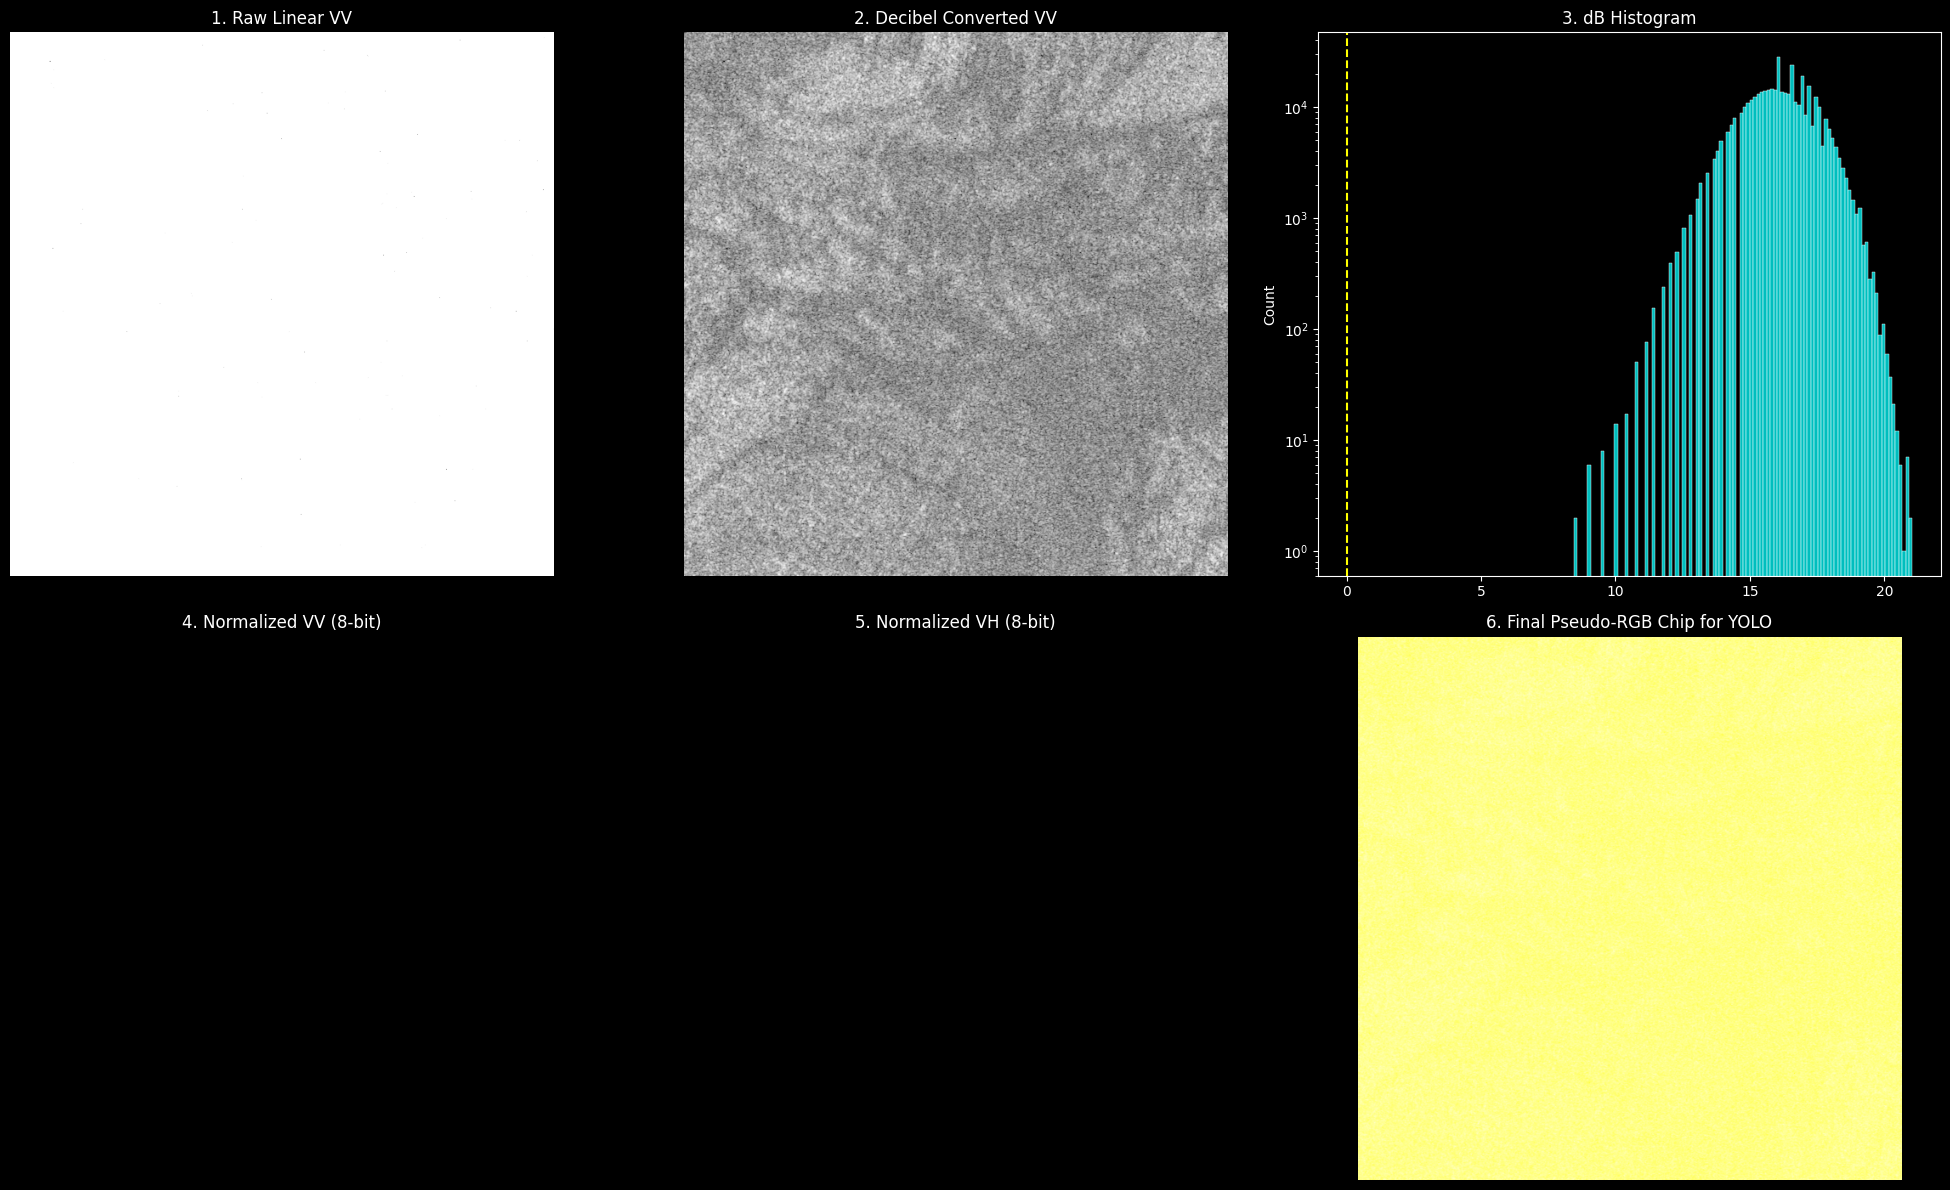

In [26]:
# Visualize 1 ship
visualize_sar(df.iloc[10])

In [27]:
# Data split
unique_scenes = df['GRD_product_identifier'].unique().tolist()
random.seed(42)
random.shuffle(unique_scenes)

split_idx = int(len(unique_scenes) * 0.8)
train_scenes = set(unique_scenes[:split_idx])

In [28]:
# Extraction limit
max_chips = 2000
success_count = {'train': 0, 'val': 0}

for index, row in df.iterrows():
    if sum(success_count.values()) >= max_chips:
        break

    split_type = 'train' if row['GRD_product_identifier'] in train_scenes else 'val'

    if save_chip(row, split_type):
        success_count[split_type] += 1
        if sum(success_count.values()) % 50 == 0:
            print(f"Saved {success_count['train']} Train | {success_count['val']} Val chips")

print(f"Extraction done")

Saved 50 Train | 0 Val chips
Saved 100 Train | 0 Val chips
Saved 150 Train | 0 Val chips
Saved 200 Train | 0 Val chips
Saved 235 Train | 15 Val chips
Saved 241 Train | 59 Val chips
Saved 291 Train | 59 Val chips
Saved 341 Train | 59 Val chips
Saved 391 Train | 59 Val chips
Saved 441 Train | 59 Val chips
Saved 491 Train | 59 Val chips
Saved 541 Train | 59 Val chips
Saved 591 Train | 59 Val chips
Saved 641 Train | 59 Val chips
Saved 691 Train | 59 Val chips
Saved 741 Train | 59 Val chips
Saved 791 Train | 59 Val chips
Saved 841 Train | 59 Val chips
Saved 891 Train | 59 Val chips
Saved 941 Train | 59 Val chips
Saved 962 Train | 88 Val chips
Saved 962 Train | 138 Val chips
Saved 962 Train | 188 Val chips
Saved 962 Train | 238 Val chips
Saved 962 Train | 288 Val chips
Saved 962 Train | 338 Val chips
Saved 962 Train | 388 Val chips
Saved 962 Train | 438 Val chips
Saved 962 Train | 488 Val chips
Saved 962 Train | 538 Val chips
Saved 962 Train | 588 Val chips
Saved 962 Train | 638 Val chips
Sa

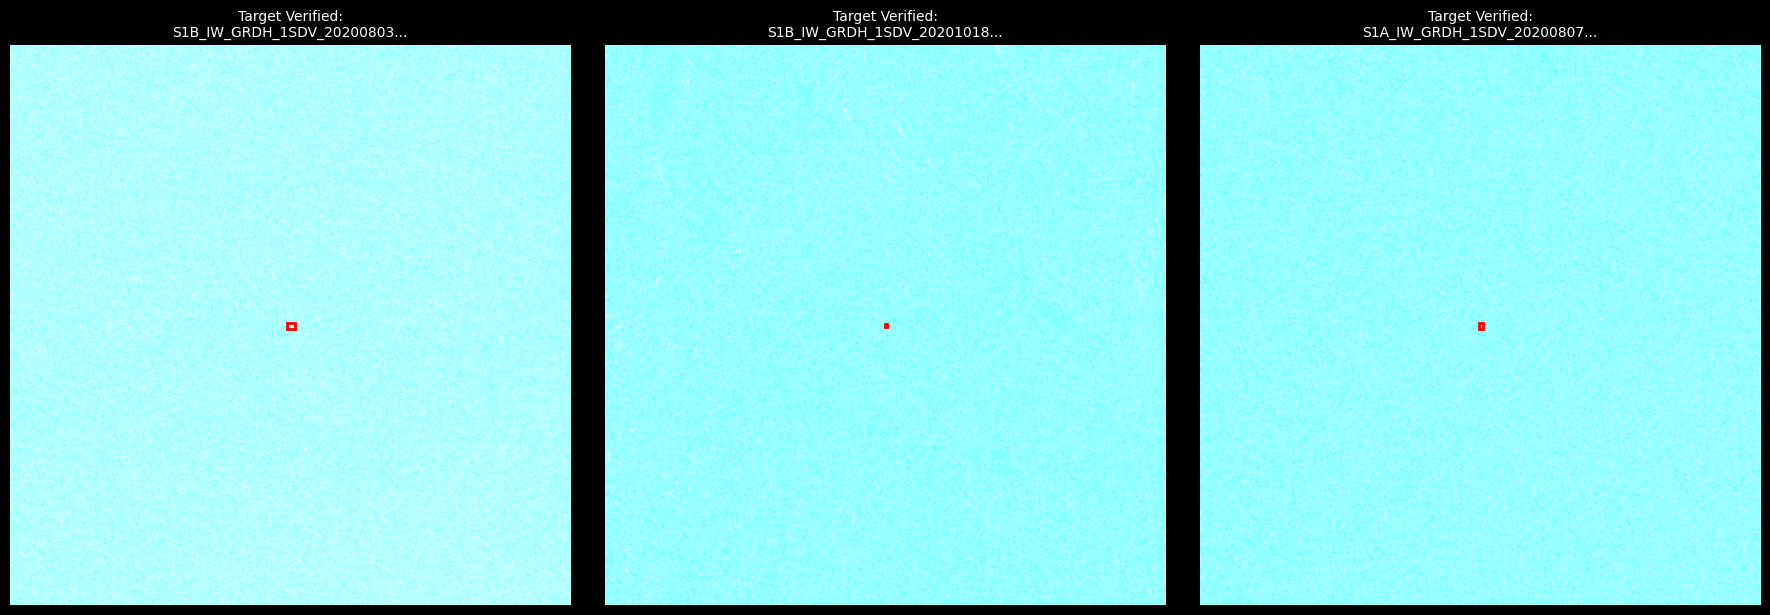

In [30]:

def visualize_saved_yolo_dataset(num_samples=3):

    train_images = glob.glob(os.path.join(DIRS['train_img'], '*.png'))

    if len(train_images) == 0:
        print("No images found in Drive. Make sure the extraction loop saved files.")
        return

    # Pick sample to inspec
    samples = random.sample(train_images, min(num_samples, len(train_images)))

    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, len(samples), figsize=(18, 6))
    if num_samples == 1: axes = [axes]

    for ax, img_path in zip(axes, samples):
        # Load img
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        chip_size = img.shape[0] # Should be 640

        # Find label
        lbl_path = img_path.replace('images', 'labels').replace('.png', '.txt')

        ax.imshow(img)
        ax.axis('off')

        # Read coordinates and draw bounding box
        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                # Format: class, x_center, y_center, width, height
                label_data = f.read().strip().split()
                if len(label_data) == 5:
                    x_c, y_c, w, h = map(float, label_data[1:])

                    # Convert YOLO percentages back to exact pixels
                    box_w, box_h = w * chip_size, h * chip_size
                    box_x = (x_c * chip_size) - (box_w / 2)
                    box_y = (y_c * chip_size) - (box_h / 2)

                    # Draw the Red Bounding Box
                    rect = patches.Rectangle((box_x, box_y), box_w, box_h,
                                             linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)

            # File name is title
            filename = os.path.basename(img_path)
            ax.set_title(f"Target Verified:\n{filename[:25]}...", fontsize=10)
        else:
            ax.set_title("Missing Label File!", color='red')

    plt.tight_layout()
    plt.show()
!
visualize_saved_yolo_dataset(num_samples=3)